# Image classification: cats & dogs

In [2]:
# Handle imports up-front
import glob
import random
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image


2024-11-27 03:22:30.746954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Data preparation

### 1.1. Load the data paths

In [3]:
# Set the path to the training data
training_data_path='../train/data/train'

# Get a list of training dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dog/dog.*')
training_cats=glob.glob(f'{training_data_path}/cat/cat.*')

### 1.2. Inspect

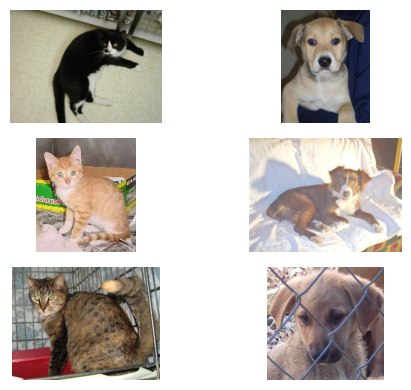

In [4]:
fig, axs = plt.subplots(3,2,figsize=(6, 4))

for cat, dog, row in zip(training_cats, training_dogs, axs):
    for animal, ax in zip([cat, dog], row):
        animal=image.load_img(animal)
        animal=image.img_to_array(animal)
        animal/=255.0
        ax.imshow(animal)
        ax.axis('off')

plt.tight_layout()
plt.show()

## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [5]:
# Load one of the dogs
dog=image.load_img(training_dogs[0])

# And convert it to an array - this is how TensorFlow will handel the data
dog=image.img_to_array(dog)

# Take a look at some properties of the object
print(f'Image data is: {type(dog)}')
print(f'Image data shape: {dog.shape}')

Image data is: <class 'numpy.ndarray'>
Image data shape: (500, 390, 3)


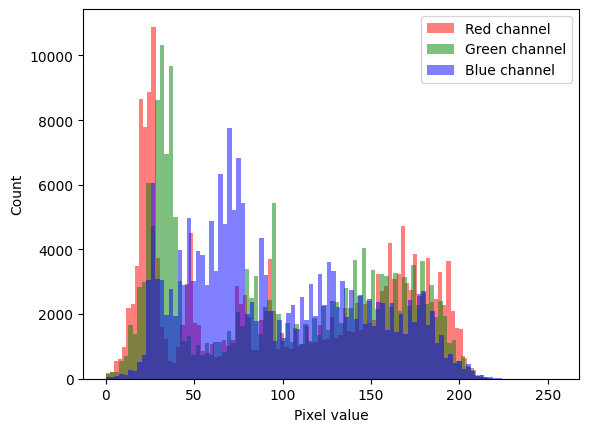

In [6]:
plt.hist(dog[:,:,0].flatten(), bins=100, color='red', alpha=0.5, label='Red channel')
plt.hist(dog[:,:,1].flatten(), bins=100, color='green', alpha=0.5, label='Green channel')
plt.hist(dog[:,:,2].flatten(), bins=100, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel('Pixel value')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

### 2.3. Image aspect ratios

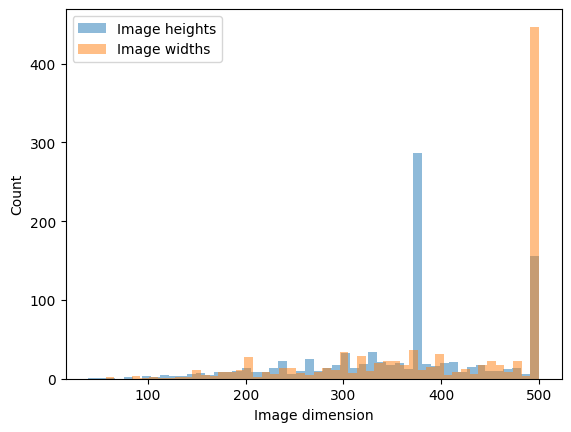

In [7]:
sample_size=1000
sample=random.sample(training_dogs, sample_size//2)
sample+=random.sample(training_cats, sample_size//2)

heights=[]
widths=[]

for sample_image in sample:

    sample_image=image.load_img(sample_image)
    sample_image=image.img_to_array(sample_image)
    heights.append(sample_image.shape[0])
    widths.append(sample_image.shape[1])

plt.hist(heights, bins=50, alpha=0.5, label='Image heights')
plt.hist(widths, bins=50, alpha=0.5, label='Image widths')
plt.xlabel('Image dimension')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

In [8]:
image_dim=128

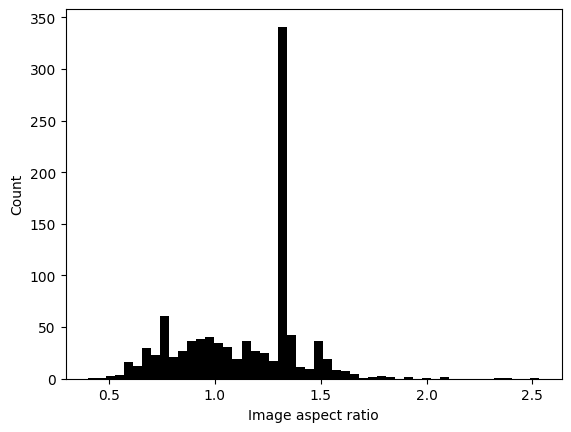

In [9]:
aspect_ratios=np.array(widths)/np.array(heights)

plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

In [10]:
image_width=image_dim
image_height=int(image_dim / (4/3))
print(f'Image input dimensions: {image_width} x {image_height}')

Image input dimensions: 128 x 96


In [11]:
def make_datasets(training_data_path, image_width, image_height, batch_size: int=32):

    training_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='training',
        seed=315,
        image_size=(image_width, image_height),
        color_mode='grayscale',
        batch_size=batch_size
    )

    validation_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='validation',
        seed=315,
        image_size=(image_width, image_height),
        color_mode='grayscale',
        batch_size=batch_size
    )

    return training_dataset, validation_dataset

training_dataset, validation_dataset=make_datasets(training_data_path, image_width, image_height)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


### 3.1. Model definition

In [12]:
def compile_model(training_dataset, image_width, image_height, learning_rate):

    # Define and adapt a normalization layer this step calculates the 
    # mean and standard deviation that will be used to normalize the data
    sample_data=training_dataset.take(1000)
    adapt_data=sample_data.map(lambda x, y: x)

    norm_layer=tf.keras.layers.Normalization()
    norm_layer.adapt(adapt_data)

    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    model=Sequential([
        layers.Input((image_width, image_height, 1)),
        norm_layer,
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model

model=compile_model(training_dataset, image_width, image_height, 0.001)
model.summary()

2024-11-27 03:24:09.915761: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 128, 96, 1)     │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 96, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,596,420 (6.09 MB)

 Trainable params: 1,596,417 (6.09 MB)

 Non-trainable params: 3 (16.00 B)

In [13]:
training_results=model.fit(
  training_dataset.repeat(),
  validation_data=validation_dataset.repeat(),
  epochs=10,
  steps_per_epoch=50,
  validation_steps=50
)

Epoch 1/10


2024-11-27 03:24:12.578178: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2024-11-27 03:24:14.479396: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24772608 exceeds 10% of free system memory.
2024-11-27 03:24:14.572991: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26542080 exceeds 10% of free system memory.
2024-11-27 03:24:14.657542: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


 1/50 ━━━━━━━━━━━━━━━━━━━━ 3:45 5s/step - binary_accuracy: 0.5625 - loss: 0.6895

2024-11-27 03:24:14.739728: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - binary_accuracy: 0.4993 - loss: 0.7831 - val_binary_accuracy: 0.5769 - val_loss: 0.6811
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 364ms/step - binary_accuracy: 0.5674 - loss: 0.6758 - val_binary_accuracy: 0.6531 - val_loss: 0.6160
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 365ms/step - binary_accuracy: 0.6622 - loss: 0.6264 - val_binary_accuracy: 0.6812 - val_loss: 0.5972
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 359ms/step - binary_accuracy: 0.6844 - loss: 0.5843 - val_binary_accuracy: 0.6891 - val_loss: 0.5734
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step - binary_accuracy: 0.7149 - loss: 0.5773 - val_binary_accuracy: 0.7356 - val_loss: 0.5309
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 280ms/step - binary_accuracy: 0.7294 - loss: 0.5485 - val_binary_accuracy: 0.7106 - val_loss: 0.5639
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - binary_accuracy: 0.7050 - loss: 0.5635 - val_binary_accuracy: 0.7513 - val_loss: 0.5203
Epoch 8/10

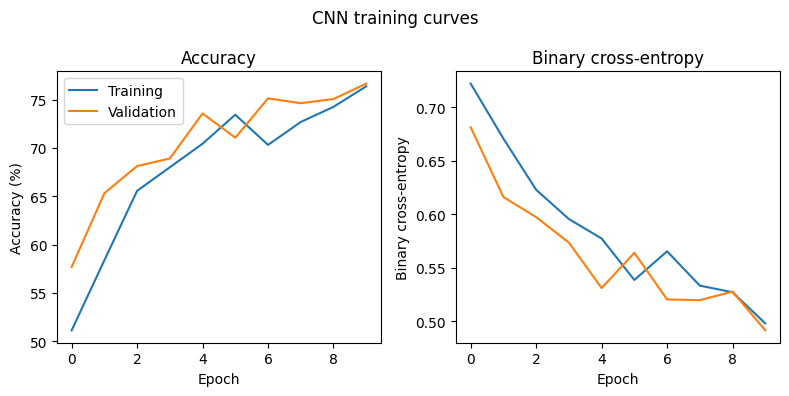

In [14]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
learning_rates=[0.001,0.0001,0.00001]
batch_sizes=[64,128,256]
training_results=[]

conditions=list(itertools.product(batch_sizes, learning_rates))

for i, parameters in enumerate(conditions):

    batch_size, learning_rate=parameters

    print(f'\nStarting training run {i + 1} of {len(learning_rates) * len(batch_sizes)}: batch size: {batch_size}, learning rate: {learning_rate}')

    training_dataset, validation_dataset=make_datasets(training_data_path, image_width, image_height, batch_size)
    model=compile_model(training_dataset, image_width, image_height, learning_rate)

    early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

    training_result=model.fit(
        training_dataset.repeat(),
        validation_data=validation_dataset.repeat(),
        epochs=10,
        steps_per_epoch=20,
        validation_steps=20,
        callbacks=[early_stopping]
    )

    training_results.append(training_result)


Starting training run 1 of 9: batch size: 64, learning rate: 0.001


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Epoch 1/10


2024-11-27 03:28:01.926046: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 594ms/step - binary_accuracy: 0.5088 - loss: 0.8785 - val_binary_accuracy: 0.5734 - val_loss: 0.6871
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 573ms/step - binary_accuracy: 0.5505 - loss: 0.6859 - val_binary_accuracy: 0.6695 - val_loss: 0.6504
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 566ms/step - binary_accuracy: 0.5996 - loss: 0.6606 - val_binary_accuracy: 0.6492 - val_loss: 0.6323
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 548ms/step - binary_accuracy: 0.6572 - loss: 0.6193 - val_binary_accuracy: 0.6618 - val_loss: 0.6168
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 547ms/step - binary_accuracy: 0.6714 - loss: 0.6194 - val_binary_accuracy: 0.6914 - val_loss: 0.5946
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 554ms/step - binary_accuracy: 0.6583 - loss: 0.6198 - val_binary_accuracy: 0.7211 - val_loss: 0.5573
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 553ms/step - binary_accuracy: 0.6911 - loss: 0.5905 - val_binary_accuracy: 0.6992 - val_loss: 0.5774
Epoch 8/10

2024-11-27 03:33:16.648753: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 541ms/step - binary_accuracy: 0.5302 - loss: 0.6915 - val_binary_accuracy: 0.5680 - val_loss: 0.6856
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - binary_accuracy: 0.5446 - loss: 0.6883 - val_binary_accuracy: 0.6062 - val_loss: 0.6780
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - binary_accuracy: 0.5643 - loss: 0.6805 - val_binary_accuracy: 0.5734 - val_loss: 0.6788
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 525ms/step - binary_accuracy: 0.6006 - loss: 0.6742 - val_binary_accuracy: 0.6021 - val_loss: 0.6710
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 532ms/step - binary_accuracy: 0.5963 - loss: 0.6717 - val_binary_accuracy: 0.6031 - val_loss: 0.6684
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 534ms/step - binary_accuracy: 0.5858 - loss: 0.6716 - val_binary_accuracy: 0.6258 - val_loss: 0.6561
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 523ms/step - binary_accuracy: 0.6162 - loss: 0.6603 - val_binary_accuracy: 0.6219 - val_loss: 0.6583
Epoch 8/10

2024-11-27 03:47:16.659675: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - binary_accuracy: 0.5186 - loss: 0.8089 - val_binary_accuracy: 0.5746 - val_loss: 0.6815
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - binary_accuracy: 0.5546 - loss: 0.6810 - val_binary_accuracy: 0.6046 - val_loss: 0.6462
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - binary_accuracy: 0.6355 - loss: 0.6332 - val_binary_accuracy: 0.6482 - val_loss: 0.6177
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - binary_accuracy: 0.6594 - loss: 0.6023 - val_binary_accuracy: 0.6706 - val_loss: 0.5976
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - binary_accuracy: 0.6723 - loss: 0.6050 - val_binary_accuracy: 0.7152 - val_loss: 0.5610
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - binary_accuracy: 0.7013 - loss: 0.5639 - val_binary_accuracy: 0.7338 - val_loss: 0.5353
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - binary_accuracy: 0.7327 - loss: 0.5276 - val_binary_accuracy: 0.7488 - val_loss: 0.5094
Epoch 8/10
20/20 ━━━━━━━━━━━━━━

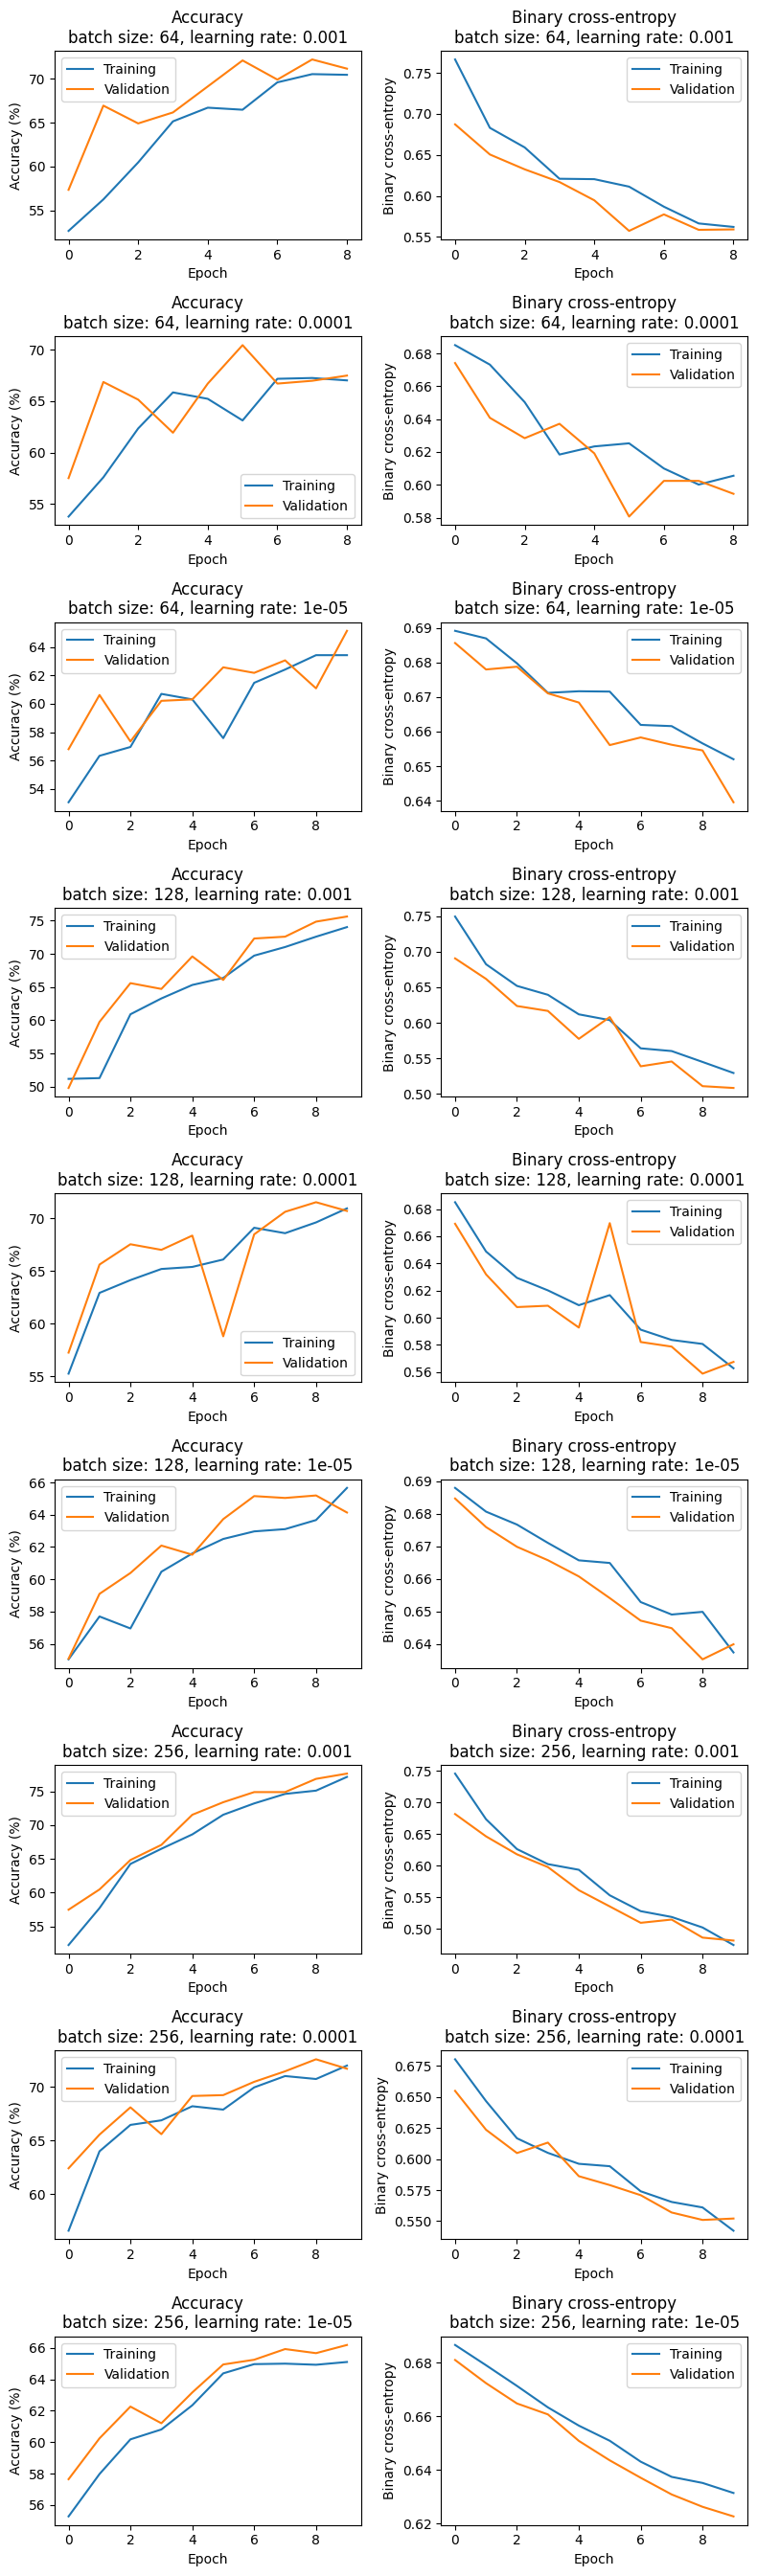

In [16]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(len(training_results), 2, figsize=(8,3*len(training_results)))

# Plot the results of each training run
for i, parameters in enumerate(conditions):
    batch_size, learning_rate=parameters
    training_result=training_results[i]

    # Plot training and validation accuracy
    axs[i,0].set_title(f'Accuracy\nbatch size: {batch_size}, learning rate: {learning_rate}')
    axs[i,0].plot(np.array(training_result.history['binary_accuracy']) * 100, label='Training')
    axs[i,0].plot(np.array(training_result.history['val_binary_accuracy']) * 100, label='Validation')
    axs[i,0].set_xlabel('Epoch')
    axs[i,0].set_ylabel('Accuracy (%)')
    axs[i,0].legend(loc='best')

    # Plot training and validation binary cross-entropy
    axs[i,1].set_title(f'Binary cross-entropy\nbatch size: {batch_size}, learning rate: {learning_rate}')
    axs[i,1].plot(training_result.history['loss'], label='Training')
    axs[i,1].plot(training_result.history['val_loss'], label='Validation')
    axs[i,1].set_xlabel('Epoch')
    axs[i,1].set_ylabel('Binary cross-entropy')
    axs[i,1].legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
batch_size=256
learning_rate=0.00001
epochs=100
steps_per_epoch=50
validation_steps=50

training_dataset, validation_dataset=make_datasets(training_data_path, image_width, image_height, batch_size)
model=compile_model(training_dataset, image_width, image_height, learning_rate)

early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

training_result=model.fit(
    training_dataset.repeat(),
    validation_data=validation_dataset.repeat(),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - binary_accuracy: 0.5560 - loss: 0.6859 - val_binary_accuracy: 0.6087 - val_loss: 0.6686
Epoch 2/100
22/50 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - binary_accuracy: 0.6020 - loss: 0.6711

In [ ]:
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_result.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_result.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_result.history['loss'])
axs[1].plot(training_result.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
plt.tight_layout()
plt.show()

I tried for so long to get my model to work. It kept crashing my kernel. I went through the main solution piece by piece and used it. I had been stuck on this one for quite a while. This took a while to run and I broke it down piece by piece but I'm glad to be done with this project. I am going to do a dive into image classification.